# Library

In [1]:
import torch
from torchvision import transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn

from glob import glob
import os
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Dataloader

In [2]:
class FrameImageDataset(torch.utils.data.Dataset):
    def __init__(self, 
    root_dir='/work3/ppar/data/ucf101',
    split='train', 
    transform=None
):
        self.frame_paths = [path.replace('\\', '/') for path in sorted(glob(f'{root_dir}/frames/{split}/*/*/*.jpg'))]
        self.df = pd.read_csv(f'{root_dir}/metadata/{split}.csv')
        self.split = split
        self.transform = transform
       
    def __len__(self):
        return len(self.frame_paths)

    def _get_meta(self, attr, value):
        return self.df.loc[self.df[attr] == value]

    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        video_name = frame_path.split('/')[-2]
        video_meta = self._get_meta('video_name', video_name)
        label = video_meta['label'].item()
        
        frame = Image.open(frame_path).convert("RGB")

        if self.transform:
            frame = self.transform(frame)
        else:
            frame = T.ToTensor()(frame)

        return frame, label

In [3]:
root_dir = os.getcwd().replace('\\', '/') + '/ufc10'

batch_size = 10

transform = T.Compose([T.Resize((64, 64)), T.ToTensor()])

train_set = FrameImageDataset(root_dir=root_dir, split='train', transform=transform)
test_set = FrameImageDataset(root_dir=root_dir, split='test', transform=transform)
val_set = FrameImageDataset(root_dir=root_dir, split='val', transform=transform)

train_loader = DataLoader(train_set,  batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set,  batch_size=batch_size, shuffle=False)

action = ['BodyWeightSquats', 'HandstandPushups', 'HandstandWalking', 'JumpingJack', 'JumpRope', 'Lunges', 'PullUps', 'PushUps', 'TrampolineJumping', 'WallPushups']

# Sample from dataset

(-0.5, 63.5, 63.5, -0.5)

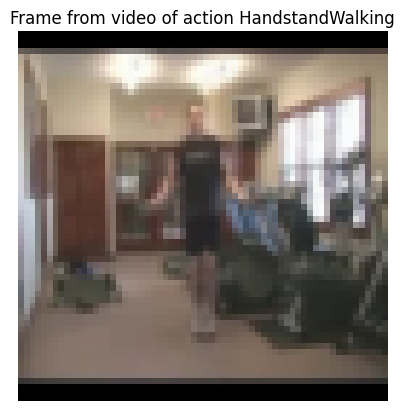

In [4]:
frames, labels = next(iter(train_loader))
label_num = labels[np.random.randint(labels.shape[0])]

plt.imshow(frames[label_num].permute(1, 2, 0).numpy())
plt.title(f"Frame from video of action {action[label_num]}")
plt.axis("off")

# 2D CNN

In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.convolutional1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.convolutional2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.convolutional3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.convolutional1(x)
        x = self.convolutional2(x)
        x = self.convolutional3(x)

        x = x.view(x.size(0), -1)

        x = self.fully_connected(x)
        x = x.squeeze(1)

        return x

In [6]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Network()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5, lr=0.001)
criterion = nn.CrossEntropyLoss()

cpu


# Training of 2D CNN

In [7]:
def train_CNN(model, dataloader, device, optimizer, criterion, num_epoch):
    for epoch in tqdm(range(num_epoch), unit='epoch'):
        model.to(device)
        model.train()

        train_loss = 0
        train_correct = 0
        train_total = 0

        for frames, labels in tqdm(dataloader, total = len(dataloader)):
            frames, labels = frames.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(frames)
            predicted = output.argmax(dim=1)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
    
        epoch_loss = train_loss / len(dataloader)
        accuracy = 100 * train_correct / train_total
        print(f"Epoch {epoch + 1}/{num_epoch}\tLoss: {epoch_loss:.4f}\tTrain Accuracy: {accuracy:.2f}%")

In [8]:
def validate_CNN(model, dataloader, device, class_names):
    model.to(device)
    model.eval()

    predictions = []
    truth = []

    with torch.no_grad():
        for frames, labels in dataloader:
            frames, labels = frames.to(device), labels.to(device)

            output = model(frames)
            predicted = output.argmax(dim = 1)

            predictions.extend(predicted.cpu().numpy())
            truth.extend(labels.cpu().numpy())
        
        predictions = np.array(predictions)
        truth = np.array(truth)

        eval_data = confusion_matrix(truth, predictions)

        TP, FP, FN, TN = [], [], [], []
        for idx, _ in enumerate(eval_data):
            TP_class = eval_data[idx, idx]
            FP_class = np.sum(eval_data[:, idx]) - eval_data[idx, idx]
            FN_class = np.sum(eval_data[idx, :]) - eval_data[idx, idx]
            TN_class = np.sum(eval_data) - (TP_class + FP_class + FN_class)

            TP.append(TP_class)
            FP.append(FP_class)
            FN.append(FN_class)
            TN.append(TN_class)

        TP, FP, FN, TN = np.array(TP), np.array(FP), np.array(FN), np.array(TN)
        model_accuracy = np.trace(eval_data) / np.sum(eval_data)
        class_accuracy = (TP + TN) / (TP + FP + FN + TN)
        class_precision = TP / (TP + FP)
        class_recall = TP / (TP + FN)
        class_f1score = 2 * class_precision * class_recall / (class_precision + class_recall)

        print(f"Model accuracy: {model_accuracy}")
        for idx, _ in enumerate(eval_data):
            print(f"Action {class_names[idx]}\t-\tAccuracy: {class_accuracy[idx]}\tPrecision: {class_precision[idx]}\tRecall: {class_recall[idx]}\tF1-score: {class_f1score[idx]}")

        sns.heatmap(eval_data, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
        plt.xlabel('Predicted Class')
        plt.ylabel('Actual Class')
        plt.title('Confusion Matrix')
        plt.show()

        return eval_data, TP, FP, FN, TN

In [ ]:
train = False

if train == True:
    epoch = 10
    train_CNN(model, train_loader, device, optimizer, criterion, epoch)
    torch.save(model.state_dict(), 'drive/MyDrive/Colab_Notebooks/aggregate_per_frame_model.pt')
else:
    model.load_state_dict(torch.load(os.getcwd().replace('\\', '/') + '/aggregate_per_frame_model.pt', map_location=device, weights_only=True))
    model.eval()

Model accuracy: 0.8883333333333333
Action BodyWeightSquats	-	Accuracy: 0.9641666666666666	Precision: 1.0	Recall: 0.6416666666666667	F1-score: 0.7817258883248732
Action HandstandPushups	-	Accuracy: 0.9708333333333333	Precision: 0.9207920792079208	Recall: 0.775	F1-score: 0.8416289592760181
Action HandstandWalking	-	Accuracy: 0.9908333333333333	Precision: 0.943089430894309	Recall: 0.9666666666666667	F1-score: 0.9547325102880659
Action JumpingJack	-	Accuracy: 0.9666666666666667	Precision: 0.7857142857142857	Recall: 0.9166666666666666	F1-score: 0.8461538461538461
Action JumpRope	-	Accuracy: 0.9975	Precision: 0.975609756097561	Recall: 1.0	F1-score: 0.9876543209876543
Action Lunges	-	Accuracy: 0.9725	Precision: 0.8320610687022901	Recall: 0.9083333333333333	F1-score: 0.8685258964143426
Action PullUps	-	Accuracy: 0.9625	Precision: 0.8378378378378378	Recall: 0.775	F1-score: 0.8051948051948051
Action PushUps	-	Accuracy: 0.9733333333333334	Precision: 0.8384615384615385	Recall: 0.9083333333333333	F

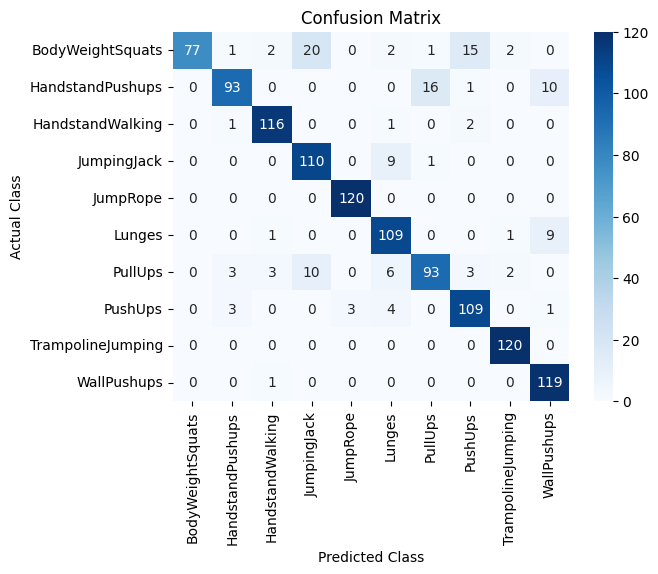

In [10]:
eval_data, TP, FP, FN, TN = validate_CNN(model, val_loader, device, action)

# Aggregator

In [11]:
def aggregate(model, dataloader, device):
    model.to(device)
    model.eval()
    prediction = []
    truth = []

    for frames, labels in dataloader:
        frames = frames.to(device)
        output = model(frames)
        predicted = output.argmax(dim = 1)

        prediction.append(predicted.tolist())
        truth.append(labels[0].item())

    prediction = torch.Tensor(prediction)
    average = torch.round(torch.mean(prediction, dim = 1))

    return average, truth

# Test

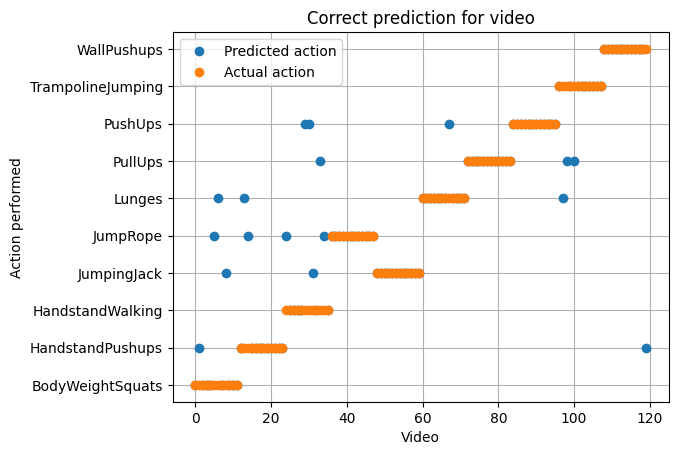

In [12]:
predicted, actual = aggregate(model, test_loader, device)

fig, ax = plt.subplots(1, 1)
ax.plot(predicted, 'o')
ax.plot(actual, 'o')
ax.set_xlabel('Video')
ax.set_ylabel('Action performed')
ax.set_title('Correct prediction for video')
ax.legend(['Predicted action', 'Actual action'])
ax.set_yticks(range(np.shape(action)[0]))
ax.set_yticklabels(action)
ax.grid()